In [1]:
def get_ytw():
    import nb_credit_spread as cslibrary
    from statsmodels.tsa.arima.model import ARIMA

    cslib = cslibrary.creditspread()
    start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'
    start_date = '2005-01-31' #'1990-01-31' # '2009-01-31'

    ytw = cslib.get_ytw_from_date_delta(start=start_date)
    return ytw

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR # , VARMAX, ARIMA

# ytw = cslib.get_ytw_from_date(start='2009-01-31', srcfile='YTW-All-Values.xlsx')
ytw = get_ytw()

print(ytw.shape)
var1, var2 = f'CS-Aaa-3MO', f'Market-RMRF' #, f'TB-3MO-TY'

import numpy as np
# ytw[f"{cs}-log"], ytw[f"{tb}-log"] = np.log(ytw[cs]), np.log(ytw[tb])

var1, var2 = f"{var1}", f"{var2}"

endog = ytw[ [var1, var2] ]
#exog = ytw['Econ-CPIAUCSL']
#print(f"endog: {endog.shape} exog: {exog.shape}")

# df = df.diff(periods=1).dropna()

length = int(len(endog) * 0.8)
train, actual = endog[0:length], endog[:] # 80% and 20% of obs

# train, actual = train.diff(periods=1).dropna(), actual.diff(periods=1).dropna()

# https://www.statsmodels.org/dev/vector_ar.html
# lag_length = 3
# model_fit = VAR(train).fit(maxlags=lag_length, ic='bic')

#Initiate VAR model
maxlag = 12
model = VAR(endog=train)
res = model.select_order(maxlag)
print(f"lag order selection:\n{res.summary()}")

model_fit = VAR(endog=train).fit(ic='bic', verbose=True) # fit VAR. select lag based on BIC info criteria
print(f"VAR model summary:\n{model_fit.summary()}")
print(f"Normality test:\n{model_fit.test_normality(signif=0.05)}")
print(f"\nGranger Causality Tests:\n")
# import statsmodels.tsa.stattools as stattools
# stattools.grangercausalitytests(x=endog[ [cs, tb] ], maxlag=12)

# The data for test whether the time series in the second column Granger causes the time series in the first column
print(model_fit.test_causality(caused=var1, causing=var2, kind='f', signif=0.05)) # 'f' - F-test. 'wald' - Wald chi-sq test
print(model_fit.test_causality(caused=var2, causing=var1, kind='f', signif=0.05))

import statsmodels.stats.diagnostic as diag
# print(model_fit.resid)
# plt.clf()
# model_fit.plot()
# model_fit.plot_acorr()    # plot correlation

(175, 52)
lag order selection:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.561       3.606       35.21       3.579
1        1.123      1.257*       3.074      1.177*
2        1.134       1.357       3.109       1.225
3        1.111       1.423       3.039       1.238
4       1.092*       1.493      2.983*       1.255
5        1.110       1.600       3.037       1.309
6        1.101       1.680       3.010       1.336
7        1.151       1.820       3.170       1.423
8        1.169       1.926       3.228       1.477
9        1.186       2.033       3.289       1.530
10       1.219       2.155       3.403       1.599
11       1.215       2.240       3.397       1.631
12       1.241       2.355       3.493       1.693
--------------------------------------------------
&lt;statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -&gt; 4, BIC 

1
VAR lag order: 1
[[ 0.85164217 -2.71890452]
 [ 0.95830971 -2.30381392]
 [ 1.05201139 -2.11872077]
 [ 1.13808113 -2.00616962]
 [ 1.21834334 -1.91880313]]


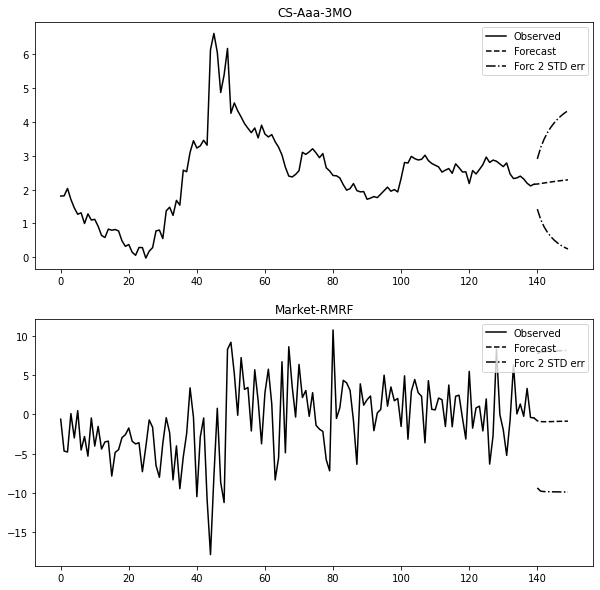

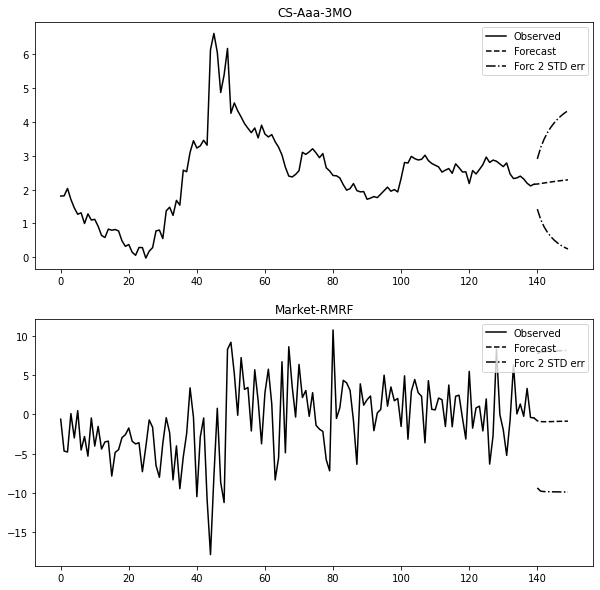

In [3]:
print(model_fit.k_ar)
lag_order = model_fit.k_ar
print(f'VAR lag order: {lag_order}')

print(model_fit.forecast(y=endog.values[-lag_order:], steps=5))

model_fit.plot_forecast(steps=10)

## Johansen Cointegration. where test statistic < critical value, then cannot reject Ho that there is atleast one co-integrating vector
#### https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.select_coint_rank.html

In [4]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
ar_diff = 1
vec_rank_trace = select_coint_rank(train, det_order = 1, k_ar_diff = ar_diff, method = 'trace', signif=0.05)
print(vec_rank_trace.summary())

vec_rank_maxeig = select_coint_rank(train, det_order = 1, k_ar_diff = ar_diff, method = 'maxeig', signif=0.05)
print(vec_rank_maxeig.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          56.91          18.40
  1   2          3.004          3.841
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          53.91          17.15
  1   2          3.004          3.841
-------------------------------------


## VECM

In [5]:
import statsmodels.tsa.vector_ar.vecm as vec
vecm = vec.VECM(endog = train, k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
vecm_fit = vecm.fit()
vecm_fit.predict(steps=10)
forecast, lower, upper = vecm_fit.predict(10, 0.05)
print(forecast)
print(actual.tail)

[[ 2.24181979  0.73406505]
 [ 2.24338598  0.23755406]
 [ 2.20329524 -1.05156963]
 [ 2.25184388 -0.13165772]
 [ 2.21790485 -0.30584342]
 [ 2.20986075  0.18026086]
 [ 2.22662032 -0.98824847]
 [ 2.26508076 -0.4319247 ]
 [ 2.2793938  -0.26010783]
 [ 2.26308251 -0.57040109]]
&lt;bound method NDFrame.tail of             CS-Aaa-3MO  Market-RMRF
Date                               
2005-01-31       1.808      -0.6197
2005-02-28       1.813      -4.6718
2005-03-31       2.033      -4.8009
2005-04-30       1.708       0.0952
2005-05-31       1.458      -3.0043
...                ...          ...
2019-03-31       0.784       1.5314
2019-04-30       0.802      -9.0078
2019-05-31       0.665       4.5430
2019-06-30       0.653      -0.8072
2019-07-31       0.715      -3.8892

[175 rows x 2 columns]&gt;


Det. terms outside the coint. relation &amp; lagged endog. parameters for equation CS-Aaa-3MO
                     coef    std err          z      P&gt;|z|      [0.025      0.975]
----------------------------------------------------------------------------------
L1.CS-Aaa-3MO     -0.0862      0.088     -0.982      0.326      -0.258       0.086
L1.Market-RMRF    -0.0241      0.015     -1.584      0.113      -0.054       0.006
L2.CS-Aaa-3MO   8.632e-05      0.088      0.001      0.999      -0.173       0.173
L2.Market-RMRF    -0.0145      0.015     -0.977      0.328      -0.044       0.015
L3.CS-Aaa-3MO      0.0277      0.089      0.311      0.756      -0.147       0.202
L3.Market-RMRF    -0.0057      0.014     -0.396      0.692      -0.034       0.022
L4.CS-Aaa-3MO      0.0913      0.090      1.017      0.309      -0.085       0.267
L4.Market-RMRF    -0.0090      0.014     -0.659      0.510      -0.036       0.018
L5.CS-Aaa-3MO      0.2437      0.089      2.732      0.006       0.069   

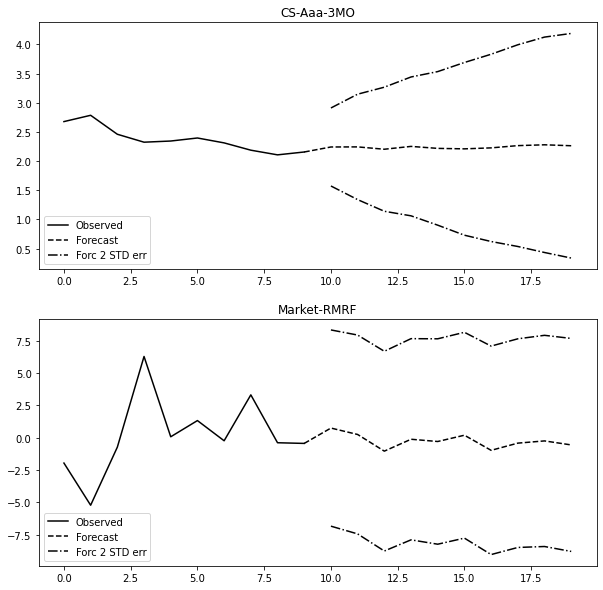

In [11]:
import statsmodels.tsa.vector_ar.vecm as vecm
vecm = vecm.VECM(endog = train, k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
vecm_fit = vecm.fit()
print(vecm_fit.summary())
vecm_fit.predict(steps=10)
vecm_fit.plot_forecast(steps=10, n_last_obs=10)
# forecast_errors = [test['CS-Aaa-3MO'][i] - forecast['CS-Aaa-3MO'][i] for i in range(len(test))]

# [print(i) for i in range(len(test))]
print(vecm_fit.resid)

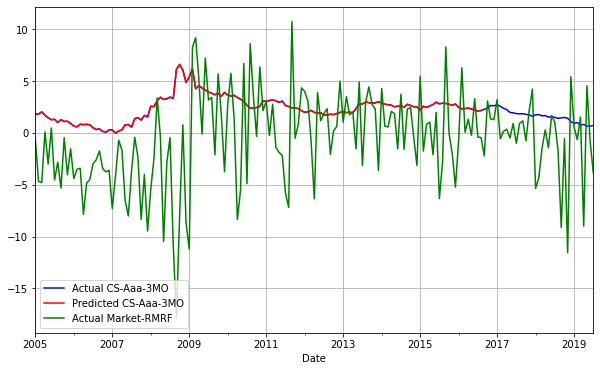

In [7]:
plt.figure(figsize=(10,6))
plt.xlabel = 'Date'

train, actual

ax1 = actual[var1].plot(color='blue', grid=True, label=f"Actual {var1}")
ax2 = train[var1].plot(color='red', grid=True, label=f"Predicted {var1}")
ax3 = actual[var2].plot(color='green', grid=True, label=f"Actual {var2}")
ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=3)
plt.show()

## IGNORE CELL BELOW. uses VAR with exog

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR # , VARMAX, ARIMA

# ytw = get_ytw_from_date(start='2009-01-31', srcfile='YTW-All-Values.xlsx')
print(ytw.shape)
corp, mat = 'Aaa', '1YR'
cs, tb = f'CS-{corp}-{mat}', f'TB-{mat}-TY'
rmrf = f'Market-SP500-change'
endog = ytw[ [cs, tb] ]
exog = ytw[ [rmrf] ]

# train, actual = endog[0:length], endog[:] # 80% and 20% of obs

model_fit = VAR(endog=endog, exog=exog).fit(ic='bic', verbose=True) # fit VAR. select lag based on BIC info criteria. ic: ‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None}

print(model_fit.params)
# coef = model_fit.params
# pred_error = coef[0]

# print(f'coef: {coef} prediction error: {pred_error} yhat: {yhat}')

lag_order = model_fit.k_ar

# print(model_fit.summary())

print(f'VAR lag order: {lag_order}')
print(model_fit.forecast(y=endog.values[-lag_order:], steps=5, exog_future=exog[:5]))   # call .summary() on forecast result

print(f'acf function: \n{model_fit.acf()}')

print(f'plot_forecast')
model_fit.plot_forecast(steps=1)

# model_fit.plot_forecast(steps=5)

print(model_fit.test_normality(signif=0.05))
print(model_fit.test_causality(tb, [cs], kind='f', signif=0.05)) # 'f' - F-test. 'wald' - Walc chi-sq test


(175, 52)
&lt;statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -&gt; 14, BIC -&gt; 1, FPE -&gt; 14, HQIC -&gt; 9&gt;
Using 1 based on bic criterion
                     CS-Aaa-1YR  TB-1YR-TY
const                  0.133920   0.165165
Market-SP500-change   -0.023276   0.000886
L1.CS-Aaa-1YR          0.949566  -0.058018
L1.TB-1YR-TY          -0.012675   0.966000
VAR lag order: 1
[[0.81947549 2.05271528]
 [0.93054774 2.09884955]
 [1.0377401  2.13688323]
 [1.02252006 2.17184008]
 [1.07767498 2.20382502]]
acf function: 
[[[ 1.11481215 -1.29984506]
  [-1.29984506  2.66735024]]

 [[ 1.07506305 -1.26809711]
  [-1.32033014  2.65207572]]]
plot_forecast


ValueError: Please provide an exog_future argument to the forecast method.